In [18]:
from pathlib import Path
import pandas as pd
from datetime import datetime

#use concat to merge all of files together
list_stacked = pd.DataFrame() 
current_path = Path()/'CSV'
for folder in current_path.absolute().glob('*'):
    for file in folder.glob('H_lvr_land_A.csv'):
        data = pd.read_csv(file)[1:]
        list_stacked = pd.concat([list_stacked, data])

#----------------------------------------------------------------------------------------------------------------------------
#Originally, there are 33 columns in the file; select 18 columns which need to be analyzed
data = list_stacked[['鄉鎮市區', '土地位置建物門牌', '土地移轉總面積平方公尺', '交易年月日', '總樓層數', '建物型態', '建物移轉總面積平方公尺', '總價元',
                     '單價元平方公尺', '主建物面積']]

#----------------------------------------------------------------------------------------------------------------------------
#坪 is the most popular unit that Taiwanese to measure the property, so we need to transfer from meter squared to 坪
data = data.copy()
data = data[data['鄉鎮市區'].notna()]
data['土地移轉總面積坪'] = data['土地移轉總面積平方公尺'].astype(float)*3.3058
data['建物移轉總面積坪'] = data['建物移轉總面積平方公尺'].astype(float)*3.3058
data['單價元坪'] = data['單價元平方公尺'].astype(float)*3.3058
data['主建物面積'] = data['主建物面積'].astype(float)*3.3058
data['總價元'] = data['總價元'].astype(float)
data['交易年月日'] = pd.to_datetime((data['交易年月日'].astype(int)+19110000).astype(str), format = '%Y%m%d', errors='coerce') #轉換成日期型態
condition = (data['交易年月日'] >= '2020-10-01') & (data['交易年月日'] <= '2023-09-30') # 篩選資料，只篩選過去36個月的資料
data = data[condition]

data['Year'] = data['交易年月日'].dt.year.fillna(0).astype(int)
data['Quarter'] = data['交易年月日'].dt.quarter.fillna(0).astype(int)
data['Month'] = data['交易年月日'].dt.month.fillna(0).astype(int).map("{:02}".format)
data['Day'] = data['交易年月日'].dt.day.fillna(0).astype(int)

# # #----------------------------------------------------------------------------------------------------------------------------

data = data.where(pd.notnull(data), None)

# # # #----------------------------------------------------------------------------------------------------------------------------


In [19]:
# 中文亂碼問題
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import date2num
from datetime import datetime
import numpy as np

def plt_chinese():
    plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] # 修改中文字體
    plt.rcParams['axes.unicode_minus'] = False # 顯示負號

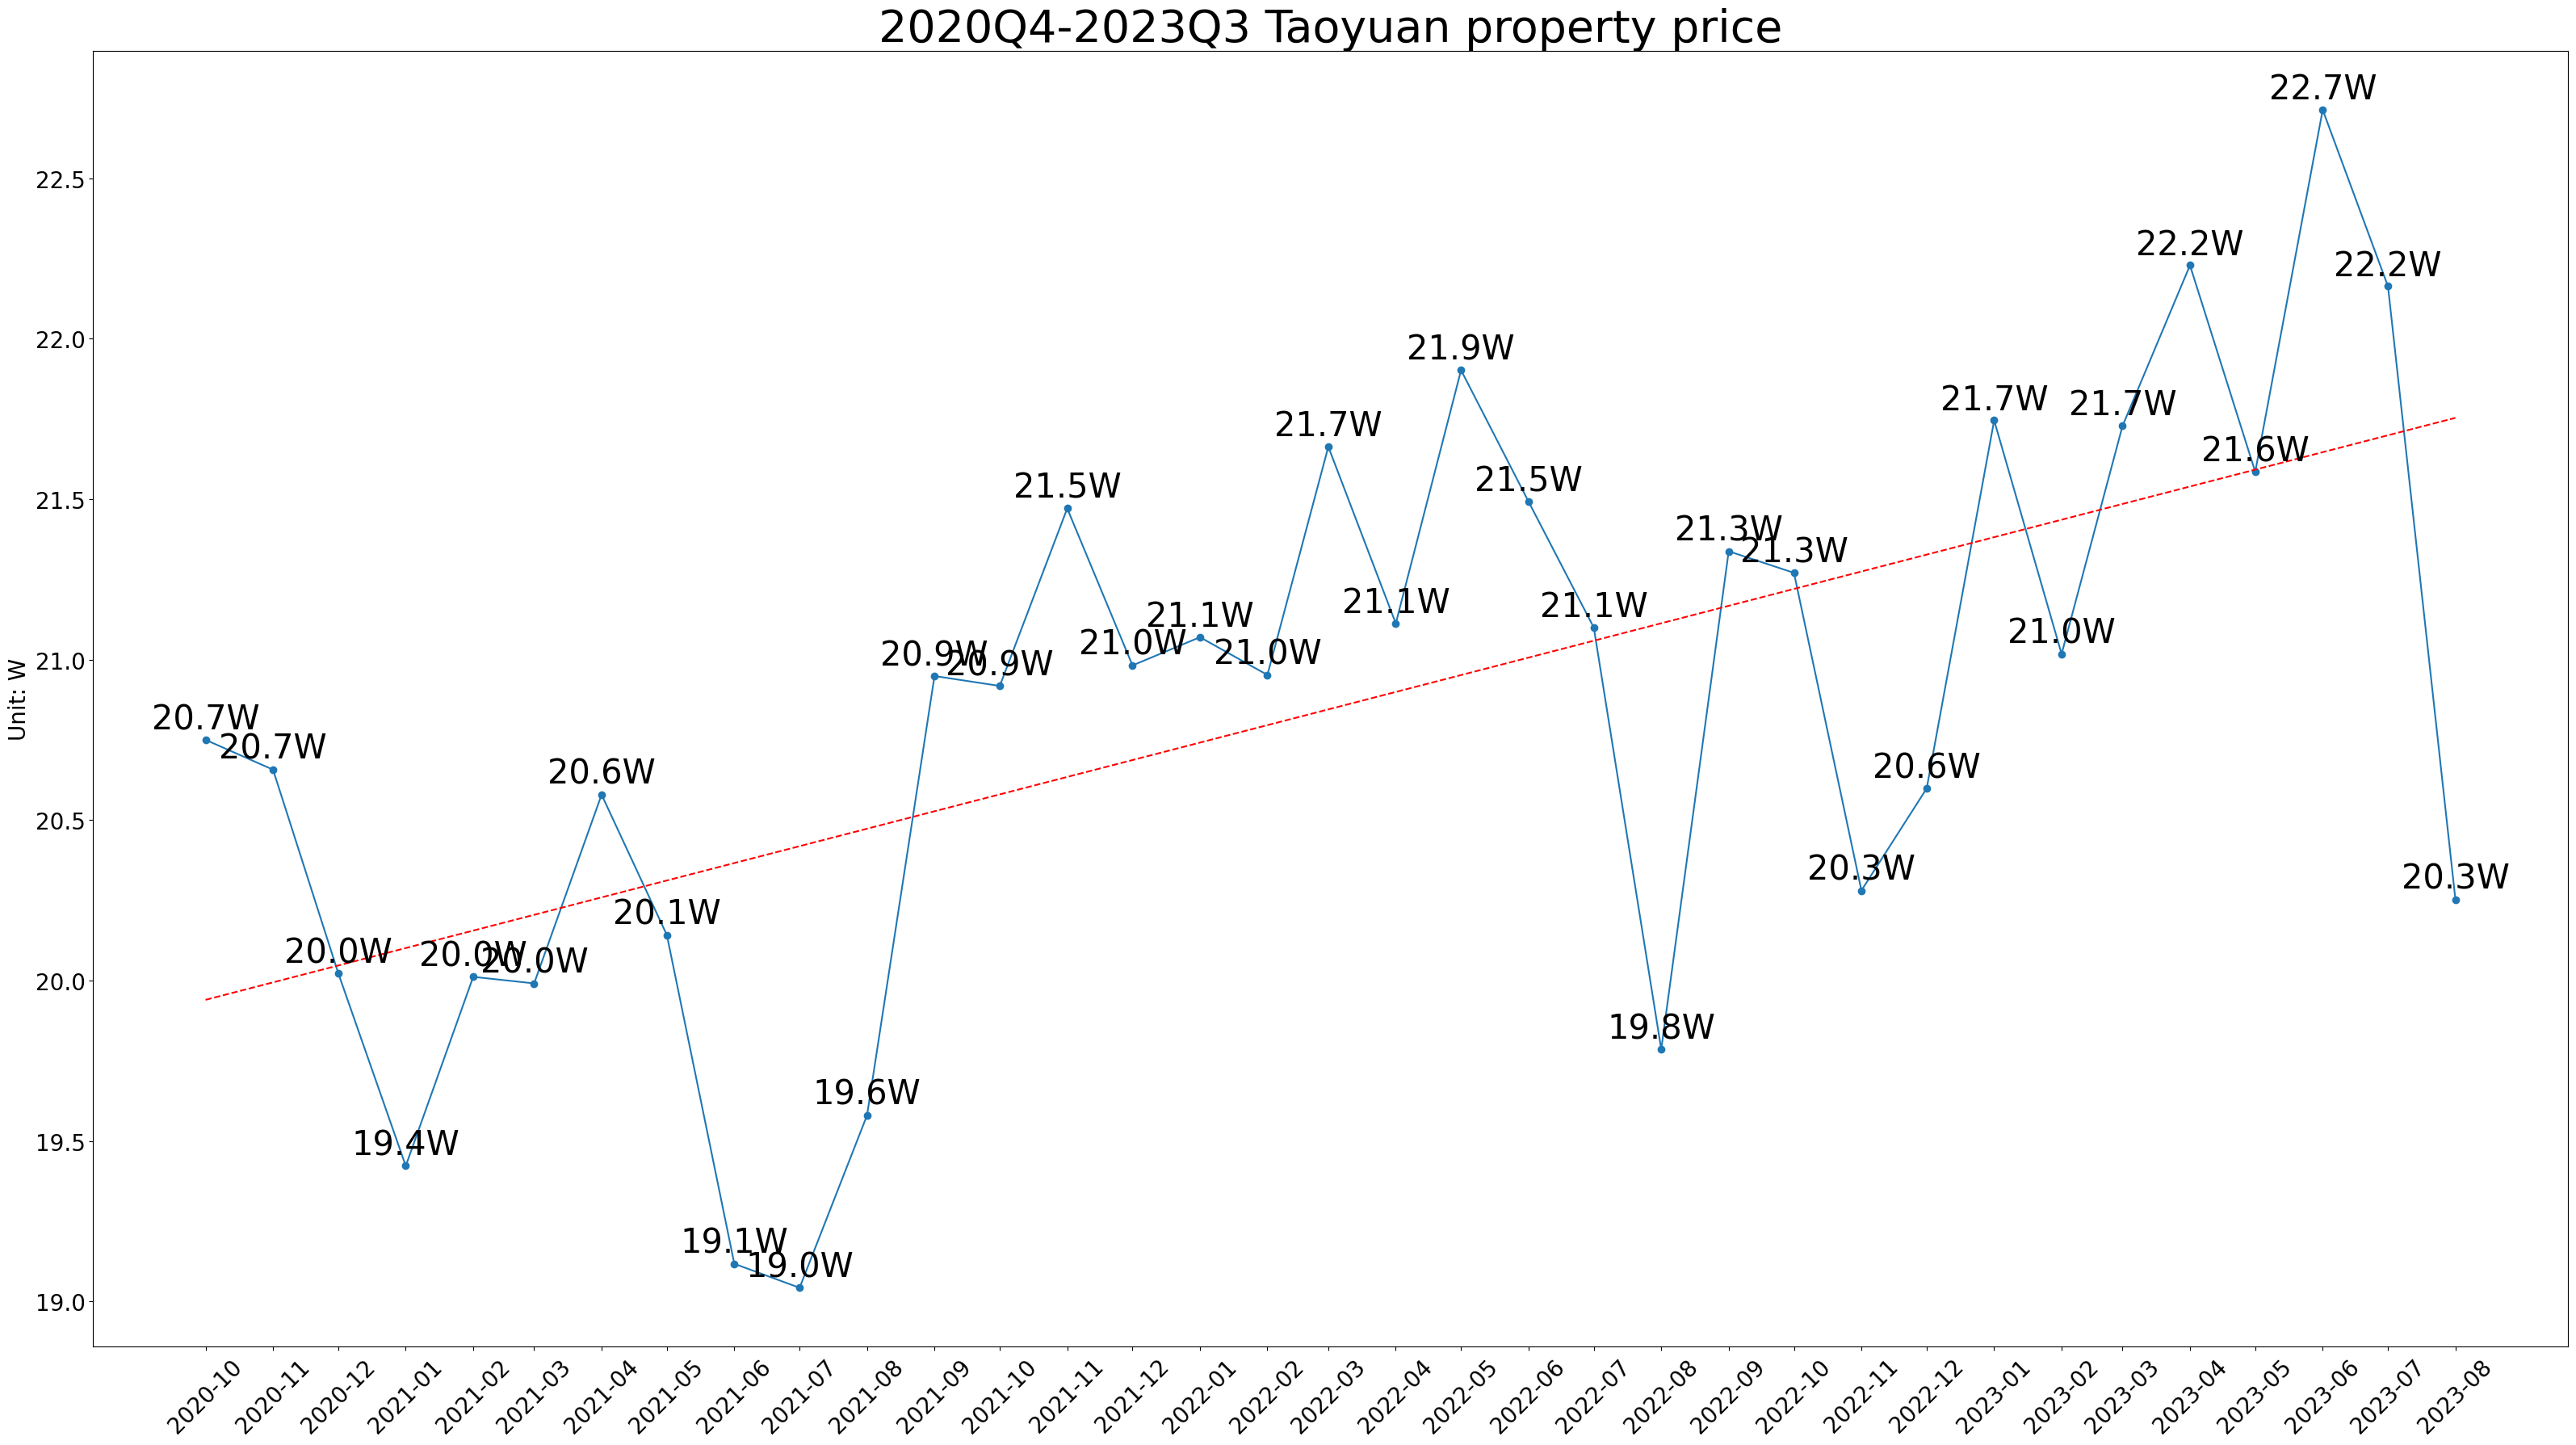

In [20]:
lst = []
for year, month in zip(data['Year'],data['Month']):
    lst.append('-'.join(str(i) for i in [year, month]))
data['Yearmonth'] = lst
data['Yearmonth'] = pd.to_datetime(data['Yearmonth'], format = '%Y-%m')

x_values = sorted(set(lst))
dates = [datetime.strptime(date, '%Y-%m') for date in x_values]
x_values_numeric = date2num(dates)

y = list(data.groupby(['Yearmonth'])['單價元坪'].mean())
y_values = [int(i)/10000 for i in y]

# # # #----------------------------------------------------------------------------------------------------------------------------

plt.figure(figsize=(32, 18))

# Convert date strings to datetime objects
dates = [datetime.strptime(date, '%Y-%m') for date in x_values]

# Convert datetime objects to numerical values
x_values_numeric = date2num(dates)

# Perform linear regression to get the trendline
coefficients = np.polyfit(x_values_numeric, y_values, 1)
trendline = np.polyval(coefficients, x_values_numeric)

# Create the line chart
plt.plot(x_values_numeric, y_values, marker='o')#, label='Your Data'
plt.plot(x_values_numeric, trendline, label='Trendline', linestyle='--', color='red')

# Set the x-axis ticks to be the original date strings
plt.xticks(x_values_numeric, x_values, rotation=45)

# Add labels and title
# plt.xlabel('Date')
plt.xticks(fontsize=20, rotation=45)
plt.ylabel('Unit: W', fontsize = 20)
plt.yticks(fontsize=20)
plt.title("2020Q4-2023Q3 Taoyuan property price", fontsize = 40)

# Annotate the data points
for i, txt in enumerate(y_values):
    plt.annotate(f'{txt:.1f}W', (x_values_numeric[i], y_values[i]), textcoords="offset points", xytext=(0,10), ha='center', size = 30)

# Show legend
# plt.legend()

# Adjust layout to prevent label overlap
plt.tight_layout()

# Show the chart
plt.show()


In [21]:
# # # #----------------------------------------------------------------------------------------------------------------------------
df = pd.DataFrame({'Date': x_values, 'Price': y_values})
df['Price'] = df['Price'].round(1)
df.transpose()

,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,33,34
Date,2020-10,2020-11,2020-12,2021-01,2021-02,2021-03,2021-04,2021-05,2021-06,2021-07,...,2022-11,2022-12,2023-01,2023-02,2023-03,2023-04,2023-05,2023-06,2023-07,2023-08
Price,20.7,20.7,20.0,19.4,20.0,20.0,20.6,20.1,19.1,19.0,...,20.3,20.6,21.7,21.0,21.7,22.2,21.6,22.7,22.2,20.3


In [37]:
# 建立新表格 data2
data2 = pd.DataFrame(data.groupby(['建物型態', 'Yearmonth'])['單價元坪'].mean()).reset_index()
data2['Yearmonth'] = pd.to_datetime(data2['Yearmonth'], format = '%Y-%m').dt.to_period('M')
data2['單價元坪'] = data2['單價元坪']/10000
property_type = ['公寓(5樓含以下無電梯)', '透天厝', '住宅大樓(11層含以上有電梯)', '華廈(10層含以下有電梯)']
original_data2 = data2

for type in property_type:
    data2 = original_data2
    # print(type)
    data2 = data2[data2['建物型態'] == type]
    print(data2)

    # # 将 Yearmonth 列转换为日期类型
    # data2['Yearmonth'] = pd.to_datetime(data2['Yearmonth'].astype(str), format='%Y-%m')

    # # 按照年月进行排序
    # data2 = data2.sort_values(by='Yearmonth')

    # # 设置图形大小
    # plt.figure(figsize=(32, 18))

    # # 绘制线形图
    # plt.plot(data2['Yearmonth'], data2['單價元坪'], marker='o', linestyle='-', color='b', label=type)

    # # 添加标题和标签
    # plt.title(f'{type}價格趨勢線')
    # plt.xlabel('年月')
    # plt.ylabel('單價元坪')

    # # 添加图例
    # plt.legend()

    # # 旋转x轴标签，以便更好地显示日期
    # plt.xticks(rotation=45)

    # # 显示图形
    # plt.show()

            建物型態 Yearmonth       單價元坪
35  公寓(5樓含以下無電梯)   2020-10  15.789886
36  公寓(5樓含以下無電梯)   2020-11  16.168293
37  公寓(5樓含以下無電梯)   2020-12  14.917102
38  公寓(5樓含以下無電梯)   2021-01  14.594677
39  公寓(5樓含以下無電梯)   2021-02  15.074769
40  公寓(5樓含以下無電梯)   2021-03  14.512486
41  公寓(5樓含以下無電梯)   2021-04  15.044298
42  公寓(5樓含以下無電梯)   2021-05  15.211784
43  公寓(5樓含以下無電梯)   2021-06  14.376361
44  公寓(5樓含以下無電梯)   2021-07  13.997262
45  公寓(5樓含以下無電梯)   2021-08  15.280905
46  公寓(5樓含以下無電梯)   2021-09  15.861663
47  公寓(5樓含以下無電梯)   2021-10  16.316342
48  公寓(5樓含以下無電梯)   2021-11  16.081929
49  公寓(5樓含以下無電梯)   2021-12  16.285868
50  公寓(5樓含以下無電梯)   2022-01  17.063364
51  公寓(5樓含以下無電梯)   2022-02  15.717424
52  公寓(5樓含以下無電梯)   2022-03  17.573352
53  公寓(5樓含以下無電梯)   2022-04  17.741702
54  公寓(5樓含以下無電梯)   2022-05  17.963189
55  公寓(5樓含以下無電梯)   2022-06  17.840564
56  公寓(5樓含以下無電梯)   2022-07  17.607005
57  公寓(5樓含以下無電梯)   2022-08  17.121294
58  公寓(5樓含以下無電梯)   2022-09  17.642615
59  公寓(5樓含以下無電梯)   2022-10  17.371437
60  公寓(5樓含以下